In [1]:
# change to directory based on your OS or set it to your trained model
tts_path = "C:\\Users\\User\\AppData\\Local\\tts\\tts_models--en--vctk--vits\\model_file.pth"
tts_config_path = "C:\\Users\\User\\AppData\\Local\\tts\\tts_models--en--vctk--vits\\config.json"
speakers_file_path = "C:\\Users\\User\\AppData\\Local\\tts\\tts_models--en--vctk--vits\\speakers.json"

In [2]:
from TTS.utils.synthesizer import Synthesizer
from IPython.display import Audio
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

c:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# We are loading a pretrained model here. You can also train your own vits/yourtts model using the recipes in the repo.
synthesizer = Synthesizer(
        tts_checkpoint=tts_path,
        tts_config_path=tts_config_path,
        tts_speakers_file=speakers_file_path,
        use_cuda=True,
    )

 > Using model: vits
 > Setting up Audio Processor...
 | > sample_rate:22050
 | > resample:False
 | > num_mels:80
 | > log_func:np.log10
 | > min_level_db:0
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:None
 | > fft_size:1024
 | > power:None
 | > preemphasis:0.0
 | > griffin_lim_iters:None
 | > signal_norm:None
 | > symmetric_norm:None
 | > mel_fmin:0
 | > mel_fmax:None
 | > pitch_fmin:None
 | > pitch_fmax:None
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:1.0
 | > clip_norm:True
 | > do_trim_silence:False
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:None
 | > base:10
 | > hop_length:256
 | > win_length:1024
 > initialization of speaker-embedding layers.


In [22]:
synthesizer.tts_model.speaker_manager.speaker_names[:5]

['ED\n', 'p225', 'p226', 'p227', 'p228']

We start with one sentence for demonstration. If you understand this, you can easily expand it for multiple sentences.

In [80]:
raw_text = "hello world this is a demonstration sentence."

In [81]:
output = synthesizer.tts(text=raw_text,speaker_name="p225",return_extra_outputs=True)
Audio(output[0], rate=22050)

 > Text splitted to sentences.
['hello world this is a demonstration sentence.']
 > Processing time: 0.5489957332611084
 > Real-time factor: 0.15449964159699103


This sentence was 3 seconds long. You can manually verify by doing `len(output[0])//22050`

In [82]:
len(output[0])//22050

3

If we see the `durations` that the model generates, they are a total of 97 numbers. However, the `sum` of these 97 numbers (which is equal to `267`) is the number of mel-spectrogram slices/frames generated. Why does the moel generate 97 numbers for durations? This is because the phonemized text is made up of 97 characters/tokens. Each token has its own duration (or the number of mel slices).

In [83]:
output[1]['outputs']['durations'].size(),output[1]['outputs']['durations'].sum()

(torch.Size([1, 1, 97]), tensor(267., device='cuda:0'))

In [84]:
tokens = synthesizer.tts_model.tokenizer.text_to_ids(raw_text)
len([synthesizer.tts_model.tokenizer.decode([y]) for y in tokens])
# len of tokens is equal to the number of phonemes in the sentence which is also equal to the number of durations.

97

Now we just replace <blnk> token with '_' for ease of reading, and plot a few graphs that will make things clearer!

In [85]:
pre_tokenized_text = [synthesizer.tts_model.tokenizer.decode([y]) for y in tokens]
# replace <blnk> with space
pre_tokenized_text = [x if x != '<BLNK>' else '_' for x in pre_tokenized_text]

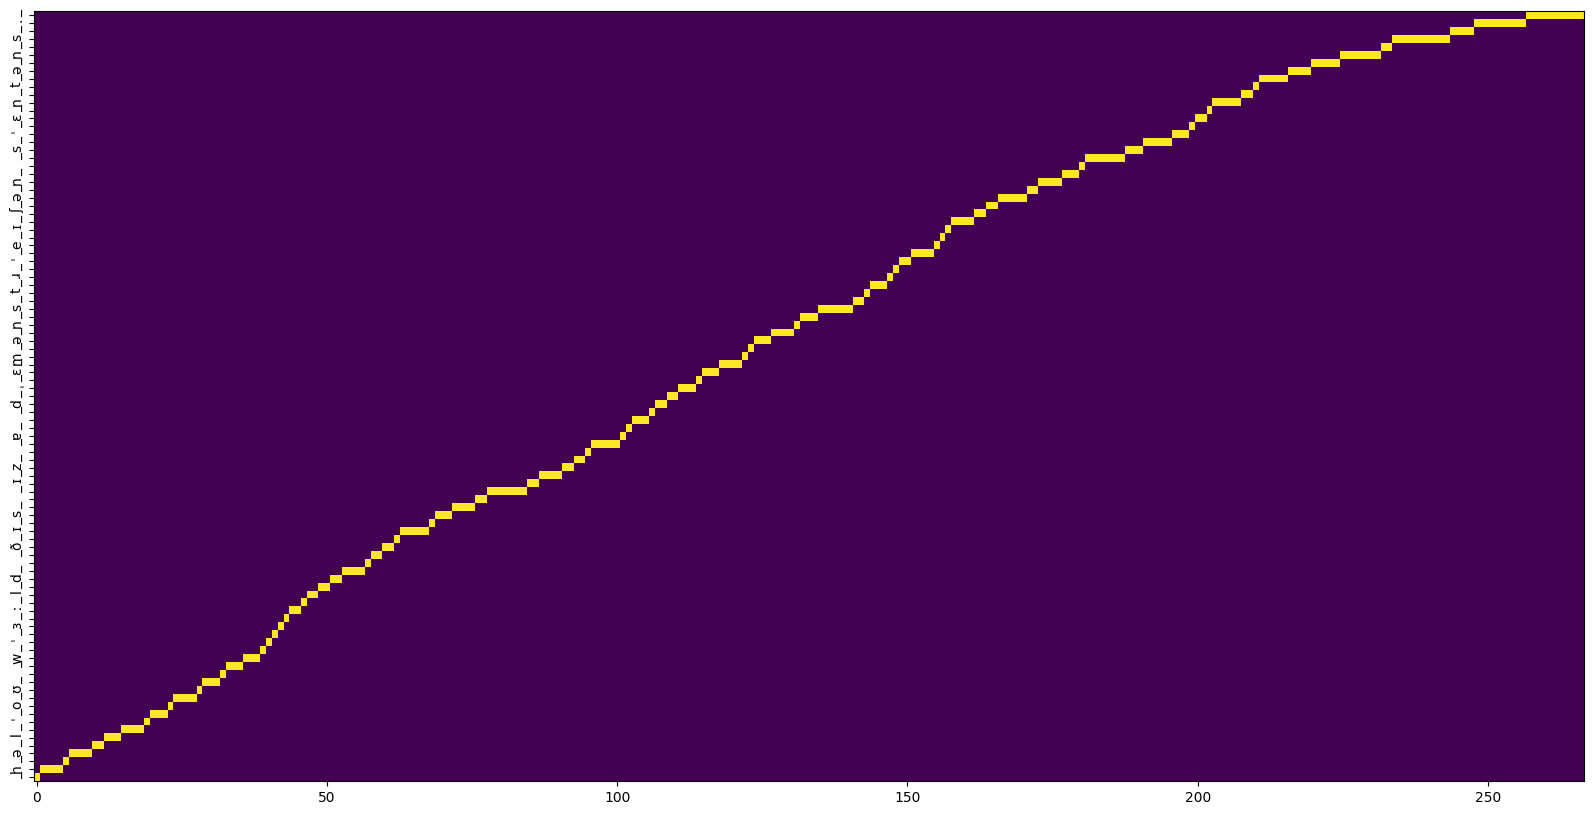

In [86]:
plt.figure(figsize=(20,10))
#plot alighnment
plt.imshow(output[1]['outputs']['alignments'][0].cpu().numpy(), origin="lower", aspect='auto', interpolation='none')
#plt imshow x tick labels
plt.yticks(range(len(pre_tokenized_text)), pre_tokenized_text, rotation=90)
plt.show()

In the above `alignment` plot we can see how many melspec slices each of the phoneme/token occupies. These were all extracted from the pre-trained model's `duration predictor` module. During training however, we use another method called `MAS` to do the same (which can be ignored right now).

In [87]:
output[1]["outputs"]["durations"].sum() # these are the number of mel slices the model wants to generate. They are occupied by the phonemes in the sentence.

tensor(267., device='cuda:0')

In the following plot we can see the melspec of the generated wav, if we align each of the frames to their respective tokens from the durations, we can see how long and when the particular token/phoneme was spoken in the speech.

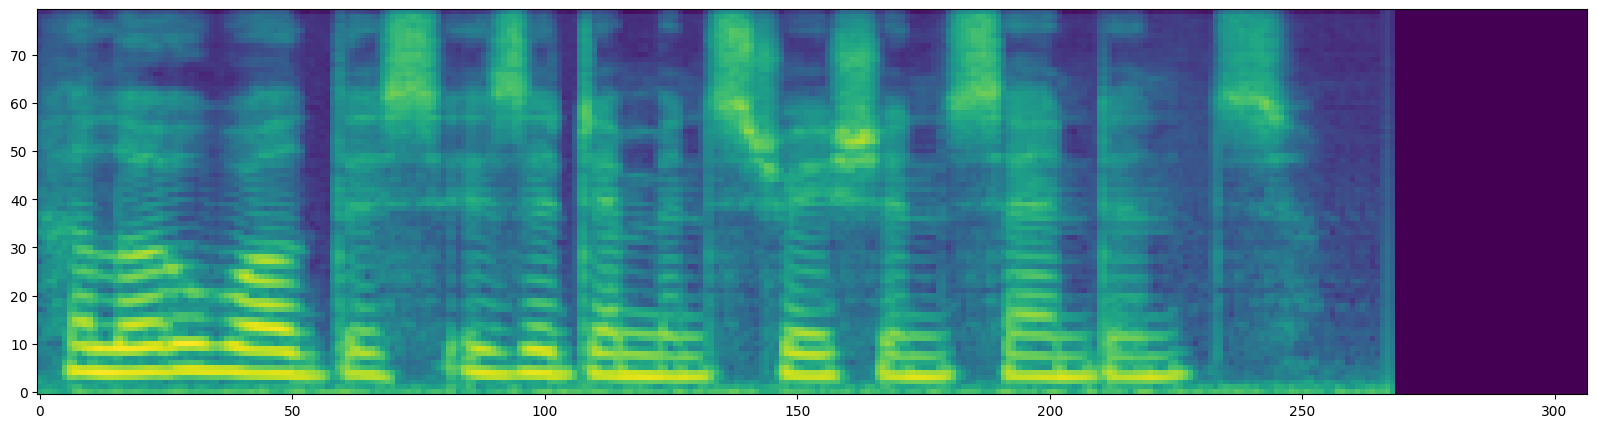

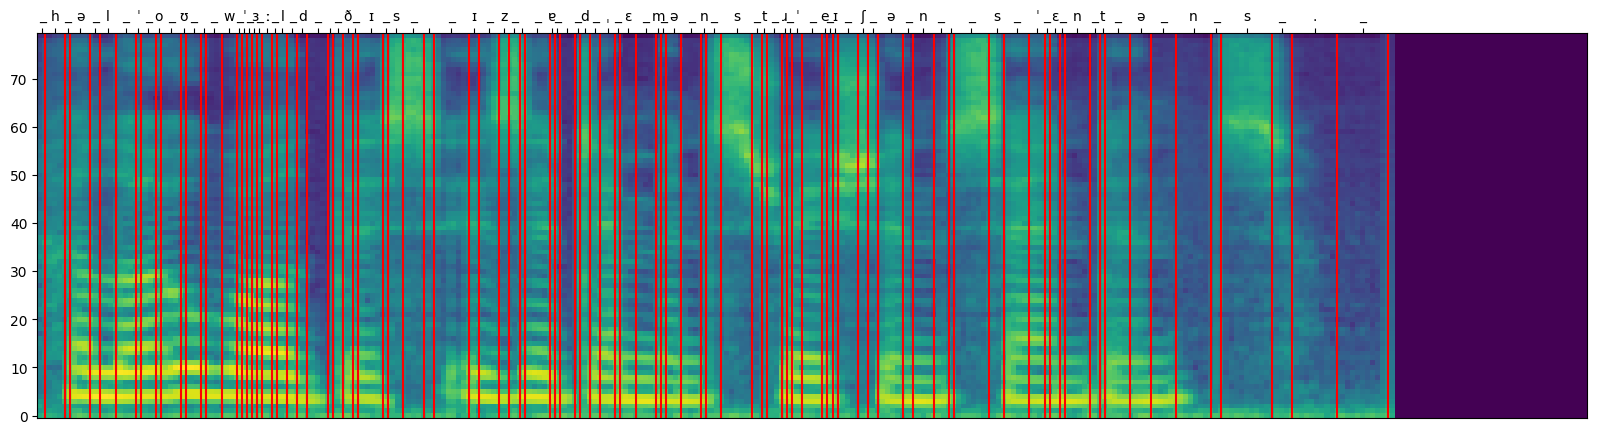

In [88]:
# plot the spectrogram
spec = synthesizer.tts_model.ap.melspectrogram(np.array(output[0]))
plt.figure(figsize=(20,5))
plt.imshow(spec, origin="lower", aspect='auto', interpolation='none')
# create xticks with pre_tokenized_text
plt.show()

# plot the spectrogram with xticks
spec = synthesizer.tts_model.ap.melspectrogram(np.array(output[0]))
plt.figure(figsize=(20,5))
plt.imshow(spec, origin="lower", aspect='auto', interpolation='none')
# create labels at the xticks
# plt.xticks(np.cumsum(output[1]["outputs"]["durations"].cpu().numpy()), pre_tokenized_text, rotation=0)
# shift the xticks to the middle of the bins
plt.xticks(np.cumsum(output[1]["outputs"]["durations"].cpu().numpy()[0][0]) - output[1]["outputs"]["durations"].cpu().numpy()[0][0] / 2, pre_tokenized_text, rotation=0)
# draw a vertical line for each token
for x in np.cumsum(output[1]["outputs"]["durations"].cpu().numpy()):
    plt.axvline(x, color='r')
#move xticks to the top
plt.gca().xaxis.tick_top()
plt.show()

Now we will manipulate the durations. First, we listen to the original wav again, and check the original durations tensor generated by the model.

In [90]:
Audio(output[0], rate=22050)

In [93]:
output[1]['outputs']['durations']

tensor([[[ 1.,  4.,  1.,  4.,  2.,  3.,  4.,  1.,  3.,  1.,  4.,  1.,  3.,  1.,
           3.,  3.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  2.,  2.,  2.,  4.,  1.,
           2.,  2.,  1.,  5.,  1.,  3.,  4.,  2.,  7.,  2.,  4.,  2.,  2.,  1.,
           5.,  1.,  1.,  3.,  1.,  2.,  2.,  3.,  1.,  3.,  4.,  1.,  1.,  3.,
           4.,  1.,  3.,  6.,  2.,  1.,  3.,  1.,  1.,  2.,  4.,  1.,  1.,  1.,
           4.,  2.,  2.,  5.,  2.,  4.,  3.,  1.,  7.,  3.,  5.,  3.,  1.,  2.,
           1.,  5.,  2.,  1.,  5.,  4.,  5.,  7.,  2., 10.,  4.,  9., 10.]]],
       device='cuda:0')

In [35]:
new_durations = output[1]['outputs']['durations'].clone()

We can see the index of each token and its durations below, so it is easy to manipulate at phoneme level. We can send these new durations back to the tts model now. I modified the code a little bit so that `durations` can be sent explicitly. 

In [164]:
list(zip(range(len(pre_tokenized_text)),pre_tokenized_text, output[1]["outputs"]["durations"].cpu().numpy()[0][0]))

[(0, '_', 1.0),
 (1, 'h', 4.0),
 (2, '_', 1.0),
 (3, 'ə', 4.0),
 (4, '_', 2.0),
 (5, 'l', 3.0),
 (6, '_', 4.0),
 (7, 'ˈ', 1.0),
 (8, '_', 3.0),
 (9, 'o', 1.0),
 (10, '_', 4.0),
 (11, 'ʊ', 1.0),
 (12, '_', 3.0),
 (13, ' ', 1.0),
 (14, '_', 3.0),
 (15, 'w', 3.0),
 (16, '_', 1.0),
 (17, 'ˈ', 1.0),
 (18, '_', 1.0),
 (19, 'ɜ', 1.0),
 (20, '_', 1.0),
 (21, 'ː', 2.0),
 (22, '_', 1.0),
 (23, 'l', 2.0),
 (24, '_', 2.0),
 (25, 'd', 2.0),
 (26, '_', 4.0),
 (27, ' ', 1.0),
 (28, '_', 2.0),
 (29, 'ð', 2.0),
 (30, '_', 1.0),
 (31, 'ɪ', 5.0),
 (32, '_', 1.0),
 (33, 's', 3.0),
 (34, '_', 4.0),
 (35, ' ', 2.0),
 (36, '_', 7.0),
 (37, 'ɪ', 2.0),
 (38, '_', 4.0),
 (39, 'z', 2.0),
 (40, '_', 2.0),
 (41, ' ', 1.0),
 (42, '_', 5.0),
 (43, 'ɐ', 1.0),
 (44, '_', 1.0),
 (45, ' ', 3.0),
 (46, '_', 1.0),
 (47, 'd', 2.0),
 (48, '_', 2.0),
 (49, 'ˌ', 3.0),
 (50, '_', 1.0),
 (51, 'ɛ', 3.0),
 (52, '_', 4.0),
 (53, 'm', 1.0),
 (54, '_', 1.0),
 (55, 'ə', 3.0),
 (56, '_', 4.0),
 (57, 'n', 1.0),
 (58, '_', 3.0),
 (59, '

In [167]:
pre_tokenized_text[15:33] # say, we want to stretch these phonemes

['w',
 '_',
 'ˈ',
 '_',
 'ɜ',
 '_',
 'ː',
 '_',
 'l',
 '_',
 'd',
 '_',
 ' ',
 '_',
 'ð',
 '_',
 'ɪ',
 '_']

In [166]:
new_durations[0][0][15:22] *= 3 #say, we want to make certain phonemes 3 times longer

TIP : Although durations are supposed to be integers since they are the number of mel slices, we can still use floats and they get rounded to the nearest integer in the model internally.

In [168]:
new_durations

tensor([[[ 1.,  1.,  1.,  1.,  7.,  1.,  1.,  3.,  2.,  2.,  1.,  1.,  3.,  3.,
           2., 45., 27., 18.,  9.,  9.,  9., 27.,  2.,  2.,  1.,  3.,  2.,  3.,
           1.,  1.,  4.,  2.,  5.,  3.,  1.,  5., 10.,  3.,  1.,  1.,  3.,  1.,
           2.,  2.,  3.,  3.,  1.,  3.,  1.,  1.,  2.,  1.,  5.,  2.,  2.,  3.,
           3.,  2.,  2.,  6.,  2.,  2.,  2.,  2.,  3.,  3.,  2.,  1.,  1.,  1.,
           3.,  5.,  2.,  3.,  3.,  2.,  3.,  4.,  4.,  3.,  4.,  2.,  4.,  1.,
           4.,  1.,  5.,  1.,  9.,  2.,  1., 12.,  2.,  8.,  7., 11.,  2.]]],
       device='cuda:0')

In [170]:
#tts the text, with durations sent explicitly.
output = synthesizer.tts(text=raw_text,speaker_name="p225",return_extra_outputs=True,durations=new_durations[0])
Audio(output[0], rate=22050)

 > Text splitted to sentences.
['hello world this is a demonstration sentence.']
 > Processing time: 0.4759986400604248
 > Real-time factor: 0.09359189981927137


### BONUS CONTENT! 
We can play around with the `speaker embeddings` and combine speakers as well!
The model learns to map spk_id (integers) -> a 256 vector embedding. We can add them like physical vectors with weights and mix speaker features to generate new voices as well. We can add as many as we want, I demonstrate 2 speakers here.

In [176]:
# just gonna use the new durations for this example, for fun!
import torch

In [173]:
g1=synthesizer.tts_model.emb_g(torch.IntTensor([10]).cuda()).reshape(1,256,1)
exp=synthesizer.tts_model.waveform_decoder(output[1]['outputs']['z'].cuda(),g=g1)
Audio(exp.detach().cpu().numpy()[0][0], rate=22050)

In [174]:
g2=synthesizer.tts_model.emb_g(torch.IntTensor([0]).cuda()).reshape(1,256,1)
exp=synthesizer.tts_model.waveform_decoder(output[1]['outputs']['z'].cuda(),g=g2)
Audio(exp.detach().cpu().numpy()[0][0], rate=22050)

### MAGIC

In [178]:
g=g1*0.5 + g2*0.4 #the sum of the weights does not have to be 1, also g_i * N == g_i, that is, amplifying a single speaker with however big number is just the same vector (this physics).
exp=synthesizer.tts_model.waveform_decoder(output[1]['outputs']['z'].cuda(),g=g)
Audio(exp.detach().cpu().numpy()[0][0], rate=22050)